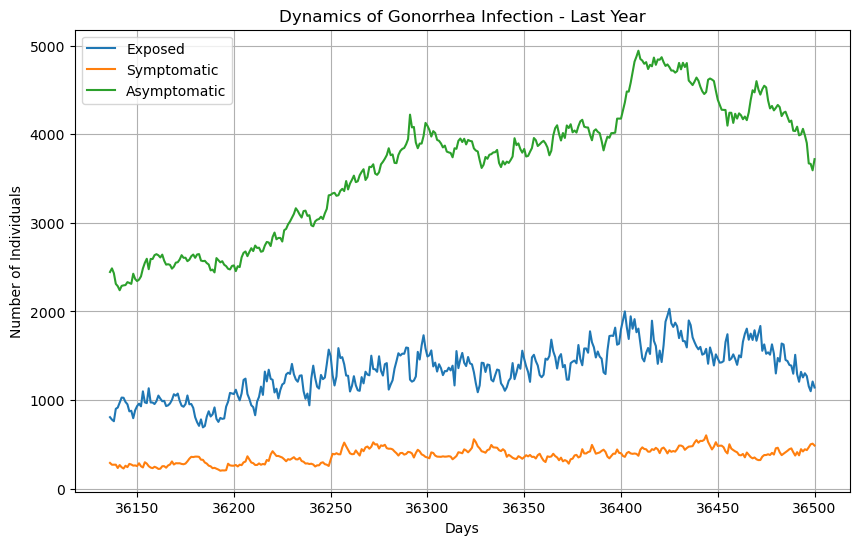

Yearly cases at steady state: 101421.36507461418
Yearly known cases at steady state: 20726.380717785752
Testing Delay: 7


In [47]:
#Stochastic Version: #Delay DE

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


def estBetaParams(mu, var):
    alpha=((1 - mu) / var - 1 / mu) * mu**2
    beta=alpha * (1 / mu - 1)
    return alpha,beta

def estGammaParams(mu,var):
    shape=(mu**2)/var
    scale=var/mu
    return shape, scale
    

#Non-Stochastic Parameters Parameters

N = 250000               # Total population
p_3months = 0.3          # Proportion tested every 3 months
p_12months = 0.7         # Proportion tested every 12 months

# Initial conditions
E0 = 0.5 * N             # Initial exposed individuals.
X0 = N - E0              # Initial susceptible individuals.
S0 = 0                   # Initial symptomatic individuals.
A0 = 0                   # Initial asymptomatic individuals.

# Define the delayed model
def gonorrhea_model_delay(Y, t, beta, epsilon, gamma_t, gamma_u, lambda_, p_3months, p_12months, tau, N):
    # Since we cannot directly use the delayed A value in the ODEs, we need to find a workaround
    # Using the history of A to find the delayed value
    A_delayed = np.interp(t - tau, t_points, A_history)
    
    X, E, S, A = Y
    
    testing_rate = (p_3months/91 + p_12months/365)
    
    dXdt = -beta * X * (S + A) / N + gamma_t * S + gamma_u * A + gamma_t*testing_rate* A_delayed
    dEdt = beta * X * (S + A) / N - epsilon * E
    dSdt = (1 - lambda_) * epsilon * E - gamma_t * S
    dAdt = lambda_ * epsilon * E - gamma_t*testing_rate * A_delayed - gamma_u * A
    
    return [dXdt, dEdt, dSdt, dAdt]

# Time array: Simulate over 10 years
t_points = np.linspace(0, 100 * 365, 100 * 365)
tau = 7 # Delay in days for getting test results

# We need to keep a history of the A compartment to look up delayed values
A_history = np.zeros(t_points.shape)
A_history[0] = A0

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6

# Loop over each day and solve the ODEs
solution = np.zeros((len(t_points), 4))
solution[0] = [X0, E0, S0, A0]


epsilons=[] #we will average these to calculate total cases later. 
lambdas=[]
for i in range(1, len(t_points)):
    
    
    
    #Stochastic params
    beta = np.random.beta(estBetaParams(0.8,0.01)[0],estBetaParams(0.8,0.01)[1])*np.random.gamma(estGammaParams(2.6,1)[0],estGammaParams(2.6,1)[1])/30        # Transmission rate, 80% infection prob * (3 partners per month)
    epsilon = 1/np.random.gamma(estGammaParams(5,1)[0],estGammaParams(5,1)[1])+0.000000000000001            # Rate of progression from exposed to infectious (inverse of latent period)
    gamma_t = (1/np.random.gamma(estGammaParams(7,1)[0],estGammaParams(7,1)[1]))+0.00000000000001            # Rate of recovery for treated individuals (they immediately get treated)
    gamma_u = np.random.beta(estBetaParams(0.6,0.01)[0],estBetaParams(0.8,0.01)[1])*(1/np.random.gamma(estGammaParams(14,3)[0],estGammaParams(14,3)[1])+0.00000000000001)      # Natural recovery rate for untreated individuals: 60% of individuals clear in two weeks.
    lambda_ = np.random.beta(estBetaParams(0.8,0.01)[0],estBetaParams(0.8,0.01)[1])         #beta with expected value 0.8 and variance 0.01 -- Proportion developing asymptomatic infection
    
    epsilons.append(epsilon)
    lambdas.append(lambda_)
    
    
    
    
    tspan = [t_points[i-1], t_points[i]]
    ys = odeint(gonorrhea_model_delay, solution[i-1], tspan, args=(beta, epsilon, gamma_t, gamma_u, lambda_, p_3months, p_12months, tau, N), atol=abserr, rtol=relerr)
    
    # Update the solution
    solution[i] = ys[-1]
    
    
    # Update A's history
    A_history[i] = ys[-1][3]

# Extract the last year's data for steady state
last_year_solution = solution[-365:]

# Calculate the yearly new cases for symptomatic and asymptomatic
yearly_symptomatic_cases = (1 - np.mean(lambdas)) * np.mean(epsilons) * np.sum(last_year_solution[:, 1])
yearly_asymptomatic_cases = np.mean(lambdas)* np.mean(epsilons) * np.sum(last_year_solution[:, 1])

# Total yearly cases are the sum of new symptomatic and asymptomatic cases
yearly_cases = yearly_symptomatic_cases + yearly_asymptomatic_cases

# Total known cases are those symptomatic and a proportion of the asymptomatic that are tested and detected
testing_proportion = (p_3months/91 + p_12months/365)  # This assumes continuous uniform testing throughout the year
yearly_known_cases = yearly_symptomatic_cases + testing_proportion * yearly_asymptomatic_cases

# Create time points for the last year
last_year_days = t_points[-365:]

# Plotting
plt.figure(figsize=(10, 6))
#plt.plot(last_year_days, last_year_solution[:, 0], label='Susceptible')
plt.plot(last_year_days, last_year_solution[:, 1], label='Exposed')
plt.plot(last_year_days, last_year_solution[:, 2], label='Symptomatic')
plt.plot(last_year_days, last_year_solution[:, 3], label='Asymptomatic')
plt.xlabel('Days')
plt.ylabel('Number of Individuals')
plt.title('Dynamics of Gonorrhea Infection - Last Year')
plt.legend()
plt.grid(True)
plt.show()

print(f"Yearly cases at steady state: {yearly_cases}")
print(f"Yearly known cases at steady state: {yearly_known_cases}")
print(f"Testing Delay: {tau}")

In [6]:


def run_simulation(tau):
    # Non-Stochastic Parameters
    N = 250000  # Total population
    p_3months = 0.3  # Proportion tested every 3 months
    p_12months = 0.7  # Proportion tested every 12 months

    # Initial conditions
    E0 = 0.5 * N
    X0 = N - E0
    S0 = 0
    A0 = 0
    
    # Define the delayed model
    def gonorrhea_model_delay(Y, t, beta, epsilon, gamma_t, gamma_u, lambda_, p_3months, p_12months, tau, N):
        # Since we cannot directly use the delayed A value in the ODEs, we need to find a workaround
        # Using the history of A to find the delayed value
        A_delayed = np.interp(t - tau, t_points, A_history)

        X, E, S, A = Y

        testing_rate = (p_3months/91 + p_12months/365)

        dXdt = -beta * X * (S + A) / N + gamma_t * S + gamma_u * A+gamma_t*testing_rate* A_delayed
        dEdt = beta * X * (S + A) / N - epsilon * E
        dSdt = (1 - lambda_) * epsilon * E - gamma_t * S
        dAdt = lambda_ * epsilon * E - gamma_t*testing_rate * A_delayed - gamma_u * A

        return [dXdt, dEdt, dSdt, dAdt]


    # Time array
    t_points = np.linspace(0, 100 * 365, 100 * 365)

    # Initialize A_history
    A_history = np.zeros(t_points.shape)
    A_history[0] = A0

    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # Initialize solution array
    solution = np.zeros((len(t_points), 4))
    solution[0] = [X0, E0, S0, A0]

    epsilons = []
    lambdas = []

    # Loop over each day and solve the ODEs
    for i in range(1, len(t_points)):
        # Stochastic parameters
        #Stochastic params
        beta = np.random.beta(10,2.5)*np.random.exponential((2/30))        # Transmission rate, 80% infection prob * (2 partners per month)
        epsilon = np.random.exponential(1/5)            # Rate of progression from exposed to infectious (inverse of latent period)
        gamma_t = np.random.exponential(1/7)            # Rate of recovery for treated individuals (they immediately get treated)
        gamma_u = np.random.beta(10,20/3)*np.random.exponential((1/14))      # Natural recovery rate for untreated individuals: 60% of individuals clear in two weeks.
        lambda_ = np.random.beta(10,2.5)         #beta with expected value 0.8 -- Proportion developing asymptomatic infection
    
        epsilons.append(epsilon)
        lambdas.append(lambda_)

        tspan = [t_points[i-1], t_points[i]]
        ys = odeint(gonorrhea_model_delay, solution[i-1], tspan, args=(beta, epsilon, gamma_t, gamma_u, lambda_, p_3months, p_12months, tau, N), atol=abserr, rtol=relerr)
        
        solution[i] = ys[-1]
        A_history[i] = ys[-1][3]

    # Post-simulation calculations
    last_year_solution = solution[-365:]
    yearly_symptomatic_cases = (1 - np.mean(lambdas)) * np.mean(epsilons) * np.sum(last_year_solution[:, 1])
    yearly_asymptomatic_cases = np.mean(lambdas) * np.mean(epsilons) * np.sum(last_year_solution[:, 1])
    yearly_cases = yearly_symptomatic_cases + yearly_asymptomatic_cases
    testing_proportion = (p_3months/91 + p_12months/365)
    yearly_known_cases = yearly_symptomatic_cases + testing_proportion * yearly_asymptomatic_cases

    return yearly_cases, yearly_known_cases

# Example usage
yearly_cases, yearly_known_cases = run_simulation(1)
print(f"Yearly cases at steady state: {yearly_cases}")
print(f"Yearly known cases at steady state: {yearly_known_cases}")

run_simulation(1)

Yearly cases at steady state: 46794.35337759077
Yearly known cases at steady state: 9553.646968231347


(179489.98681833892, 36544.25760811052)

In [9]:
# Initialize lists to store the averaged results
average_yearly_cases = []
average_known_cases = []

# Number of simulations per tau
num_simulations = 30

for tau in range(1, 10):  # Loop over tau values
    yearly_cases_results = []
    yearly_known_cases_results = []

    for _ in range(num_simulations):  # Run the simulation multiple times for each tau
        yearly_cases, yearly_known_cases = run_simulation(tau)
        yearly_cases_results.append(yearly_cases)
        yearly_known_cases_results.append(yearly_known_cases)

    # Calculate the average results for this tau
    avg_yearly_cases = np.mean(yearly_cases_results)
    avg_yearly_known_cases = np.mean(yearly_known_cases_results)

    # Store the averaged results
    average_yearly_cases.append(avg_yearly_cases)
    average_known_cases.append(avg_yearly_known_cases)

# Now, average_yearly_cases and average_known_cases contain the averaged results for each tau

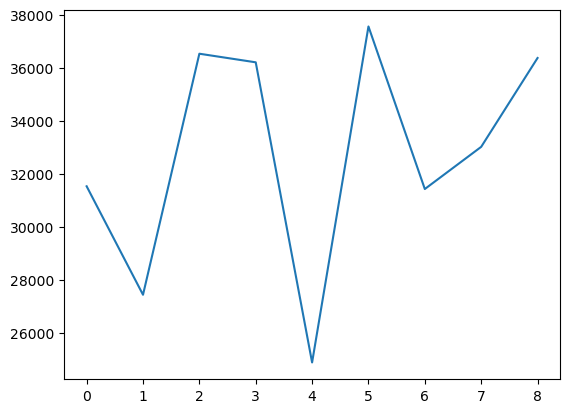

In [11]:
plt.plot(average_known_cases)

95244.75232589952 468501.5406649442


In [29]:
np.random.gamma(estGammaParams(7,0.1)[0],estGammaParams(7,0.1)[1])

7.048632541873449

In [26]:
estGammaParams(7,0.1)

(490.0, 0.014285714285714287)